# Combining Targets 4 and 7

The purpose of this notebook is to look at how our models accuracy looks when we mix targets 4 and 7 together and it takes a look at the other features sets gain/lose importance across the data

In [1]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl
#make sure to install keras if you don't have the package yet
from keras import layers, models
import h5py

## Loading in the data

In [3]:
TRIAL_1_PATH4 = "../data/target4/0115_cr4_kd_fitting_filtered_free_Imax_yint_capped_FULL.csv_mfe_structures.csv"
TRIAL_2_PATH4 = "../data/target4/1219_cr4_kd_fitting_filtered_free_Imax_yint_capped_FULL.csv_mfe_structures.csv"

TRIAL_1_PATH7 = "../data/target7/0803_cr7_kd_fitting_filtered_free_Imax_yint_capped_FULL.csv_mfe_structures.csv"
TRIAL_2_PATH7 = "../data/target7/0915_cr7_kd_fitting_filtered_free_Imax_yint_capped_FULL.csv_mfe_structures.csv"

In [5]:
df4_1 = pd.read_csv(TRIAL_1_PATH4)
df4_2 = pd.read_csv(TRIAL_2_PATH4)

df7_1 = pd.read_csv(TRIAL_1_PATH7)
df7_2 = pd.read_csv(TRIAL_2_PATH7)

### Just Target 4 Combination

In [53]:
perfect_sequence4 = 'GGGAATGGATCCACATCTACGAATTCGTA' + 'CCATAGAGAGGTTATCCGCTCA' + 'CCGAGATCGGAAGAGCACACGT'
perfect_target4 = 'CCATAGAGAGGTTATCCGCTCA'
PERFECT_KD1 = df4_1[df4_1['sequence'] == perfect_sequence4].iloc[0]['kd']
PERFECT_KD2 = df4_2[df4_2['sequence'] == perfect_sequence4].iloc[0]['kd']

df4_1['ABA'] = -(df4_1.kd/PERFECT_KD1).apply(np.log)
df4_2['ABA'] = -(df4_2.kd/PERFECT_KD2).apply(np.log)

max_aba1, min_aba1 = -np.log(1/PERFECT_KD1), -np.log(128/PERFECT_KD1)
max_aba2, min_aba2 = -np.log(1/PERFECT_KD2), -np.log(128/PERFECT_KD2)

df4_1['ABA_normalized'] = (df4_1['ABA']-min_aba1)/(max_aba1-min_aba1)
df4_2['ABA_normalized'] = (df4_2['ABA']-min_aba2)/(max_aba2-min_aba2)
df4_1.head()

merged = pd.merge(df4_1, df4_2, on= 'sequence', suffixes = ('_1', '_2'))
merged_filt = merged[(merged['kd_1'] >= 1) & (merged['kd_1'] <= 128) & (merged['kd_2'] >= 1) & (merged['kd_2'] <= 128)]

df4 = merged[['sequence','structure_1', 'mfe_1']].copy()
df4['ABA_normalized'] = (merged['ABA_normalized_1'] + merged['ABA_normalized_2'])/2
df4 = df4.rename(columns = {'structure_1': 'structure', 'mfe_1': 'mfe'} )

df4_filt = merged_filt[['sequence','structure_1', 'mfe_1']].copy()
df4_filt['ABA_normalized'] = (merged_filt['ABA_normalized_1'] + merged_filt['ABA_normalized_2'])/2
df4_filt = df4_filt.rename(columns = {'structure_1': 'structure', 'mfe_1': 'mfe'} )

In [54]:
df4_filt

,sequence,structure,mfe,ABA_normalized
0,GGGAATGGATCCACATCTACGAATTCGTACCATAGAAGGTTATCCG...,.((.((((((.(........).)))))).))......((....))(...,-11.300000,0.308932
1,GGGAATGGATCCACATCTACGAATTCGTACCAGTAGAGAGGTTATG...,.((....((((....(((((............)))))..))))......,-16.500000,0.339754
2,GGGAATGGATCCACATCTACGAATTCGTACGCATAGAGAGGTTATC...,......((((((...((((((........))..))))..))..)))...,-14.400000,0.387942
3,GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTTAGG...,.........(((..((((.((...(((((((.......)))....)...,-10.600000,0.668697
4,GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTTATC...,((((.((((((....((((((....))).....)))..))))))))...,-19.299999,0.509319
...,...,...,...,...
4924,GGGAATGGATCCACATCTACGAATTCGTACCATAGAAGAGGTTATC...,......((((((.(.((((((....))).....))).).))..)))...,-16.799999,0.509201
4925,GGGAATGGATCCACATCTACGAATTCGTACCACTAGAGAGGTTGAT...,......(((((.((.((((((....)))........))).)).)))...,-18.299999,0.578329
4926,GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGCTTATC...,......((((((...((((((....))).....)))..))...)))...,-14.700000,0.518375
4927,GGGAATGGATCCACATCTACGAATTCGTACTCATAGAGAGGGTTAT...,.(((...(((((...((((.((........)).))))..))))).)...,-19.400000,0.268102


<AxesSubplot:>

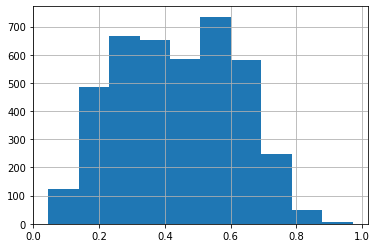

In [55]:
df4_filt['ABA_normalized'].hist()

### Just the target 7 combination

In [56]:
perfect_sequence7 = 'GGGAATGGATCCACATCTACGAATTCGTT' + 'TTTGATCTGAAATATTCAGGTC' + 'TGCAGATCGGAAGAGCACACGT'
perfect_target7 = 'TTTGATCTGAAATATTCAGGTC'
PERFECT_KD1 = df7_1[df7_1['sequence'] == perfect_sequence7].iloc[0]['kd']
PERFECT_KD2 = df7_2[df7_2['sequence'] == perfect_sequence7].iloc[0]['kd']

df7_1['ABA'] = -(df7_1.kd/PERFECT_KD1).apply(np.log)
df7_2['ABA'] = -(df7_2.kd/PERFECT_KD2).apply(np.log)

max_aba1, min_aba1 = -np.log(1/PERFECT_KD1), -np.log(128/PERFECT_KD1)
max_aba2, min_aba2 = -np.log(1/PERFECT_KD2), -np.log(128/PERFECT_KD2)

df7_1['ABA_normalized'] = (df7_1['ABA']-min_aba1)/(max_aba1-min_aba1)
df7_2['ABA_normalized'] = (df7_2['ABA']-min_aba2)/(max_aba2-min_aba2)
df7_1.head()

merged = pd.merge(df7_1, df7_2, on= 'sequence', suffixes = ('_1', '_2'))
merged_filt = merged[(merged['kd_1'] >= 1) & (merged['kd_1'] <= 128) & (merged['kd_2'] >= 1) & (merged['kd_2'] <= 128)]

df7 = merged[['sequence','structure_1', 'mfe_1']].copy()
df7['ABA_normalized'] = (merged['ABA_normalized_1'] + merged['ABA_normalized_2'])/2
df7 = df7.rename(columns = {'structure_1': 'structure', 'mfe_1': 'mfe'} )

df7_filt = merged_filt[['sequence','structure_1', 'mfe_1']].copy()
df7_filt['ABA_normalized'] = (merged_filt['ABA_normalized_1'] + merged_filt['ABA_normalized_2'])/2
df7_filt = df7_filt.rename(columns = {'structure_1': 'structure', 'mfe_1': 'mfe'} )

In [57]:
df7_filt.head()

,sequence,structure,mfe,ABA_normalized
1,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATAG...,.(((.....)))......(((....(.(((((((((((.....(((...,-13.300000,0.130714
2,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATTC...,.(((.....)))......(((....(.(((((((((((((((.......,-15.300000,0.181400
6,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAAAATTC...,.(((.....)))......(((....(.(((((((((((...........,-13.100000,0.090576
9,GGGAATGGATCCACATCTACGAATTCGTTTTCGATCTGAAATATTC...,((((((((((.(........).))))))))))((((((((...)))...,-16.799999,0.121133
11,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATTA...,.(((.....)))......(((....(.(((((((((((...........,-13.100000,0.351656


<AxesSubplot:>

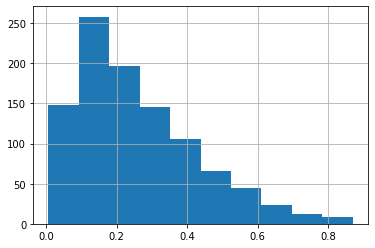

In [58]:
df7_filt['ABA_normalized'].hist()

## Relative encoding

In [85]:
#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(int(30/1.5),int(15/1.5)),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions

def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y
    
    
#think of data_matrix as input and output variable as output
#seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        #seq = sequence[29: -32]
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq[29: -22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

In [111]:
df4_encoding, aba4 = create_matrix(df4_filt, perfect_sequence = perfect_target4)

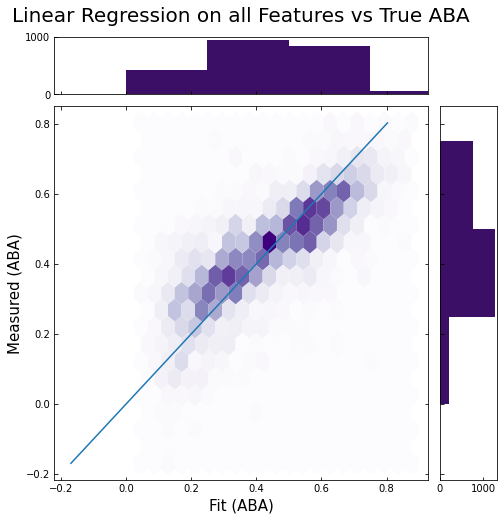

test correlation is 0.7954325352508425


In [112]:
#just to show that we aren't really over-fitting
X,y = df4_encoding, aba4

X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

In [113]:
df7_encoding, aba7 = create_matrix(df7_filt, perfect_sequence = perfect_target7)

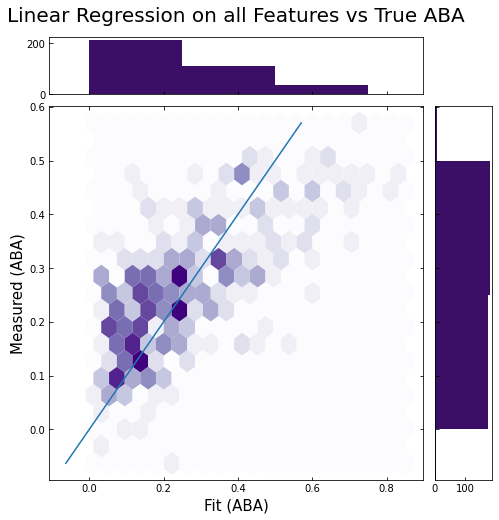

test correlation is 0.6870718156377528


In [114]:
#just to show that we aren't really over-fitting
X,y = df7_encoding, aba7

X, y = shuffle(X,y)
cutoff = 600

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

In [116]:
df4_encoding, aba4 = shuffle(df4_encoding,aba4)

#want target 4 and target 7 to be around equal weights (same number)
combined_encoding = np.concatenate((df4_encoding[:1000], df7_encoding), axis=0)

combined_aba = np.concatenate((aba4[:1000], aba7), axis=0)

(1963, 198)

In [118]:
combined_aba.shape

(1963,)

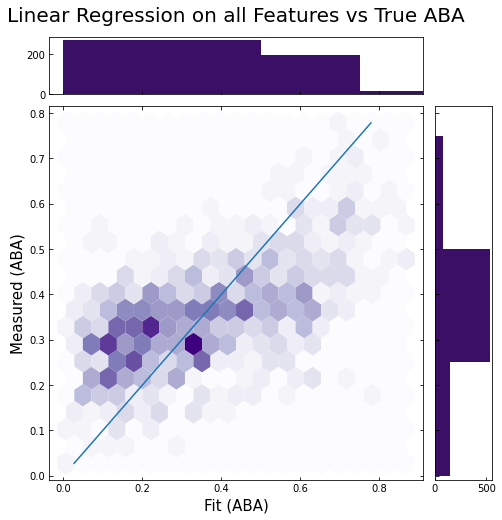

test correlation is 0.5860741284475742


In [122]:
#just to show that we aren't really over-fitting
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 1200

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

## Adding Free Energy

In [128]:
def create_matrix2(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        #seq = sequence[29: -32]
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq[29: -22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['mfe'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

In [129]:
df4_encoding, aba4 = create_matrix2(df4_filt, perfect_sequence = perfect_target4)

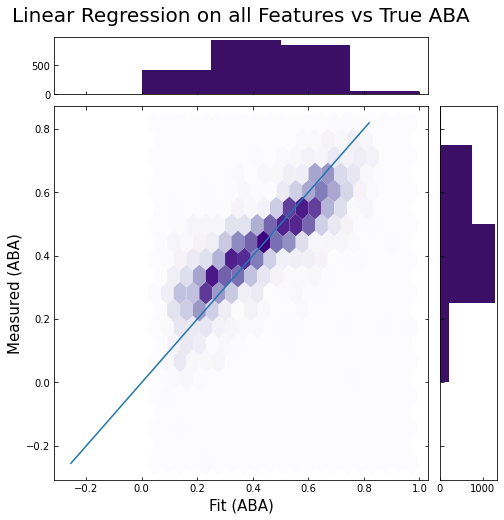

test correlation is 0.8058373165325745


In [132]:
#just to show that we aren't really over-fitting
X,y = df4_encoding, aba4

X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

In [138]:
df7_encoding, aba7 = create_matrix2(df7_filt, perfect_sequence = perfect_target7)

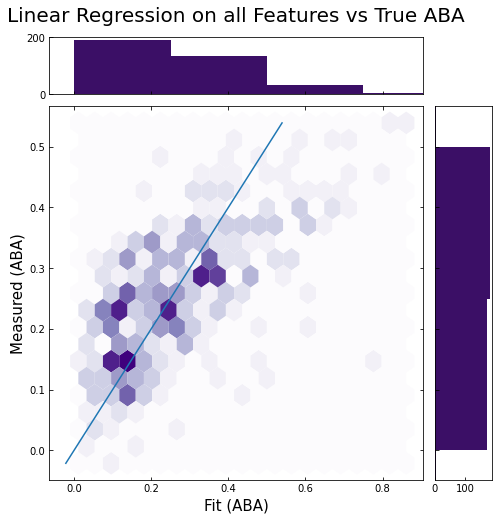

test correlation is 0.6566397982859352


In [150]:
#just to show that we aren't really over-fitting
X,y = df7_encoding, aba7

X, y = shuffle(X,y)
cutoff = 600

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

In [151]:
df4_encoding, aba4 = shuffle(df4_encoding,aba4)

#want target 4 and target 7 to be around equal weights (same number)
combined_encoding = np.concatenate((df4_encoding[:1000], df7_encoding), axis=0)

combined_aba = np.concatenate((aba4[:1000], aba7), axis=0)

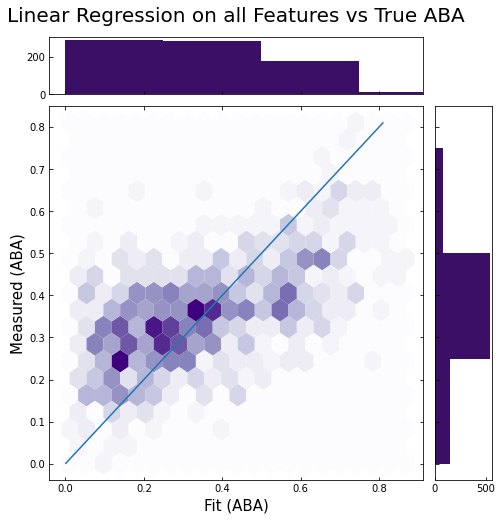

test correlation is 0.569199392643259


In [154]:
#just to show that we aren't really over-fitting
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 1200

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

In [155]:
np.corrcoef(df4['mfe'], df4['ABA_normalized'])

array([[1.       , 0.0111432],
       [0.0111432, 1.       ]])

In [156]:
df4['mfe']

0      -11.300000
1      -16.500000
2      -14.400000
3      -10.600000
4      -19.299999
          ...    
4924   -16.799999
4925   -18.299999
4926   -14.700000
4927   -19.400000
4928   -18.400000
Name: mfe, Length: 4929, dtype: float64

In [ ]:
df4_1 = pd.read_csv(TRIAL_1_PATH4)

In [157]:
np.corrcoef(df4_1 ['mfe'], df4_1 ['ABA_normalized'])

array([[ 1.        , -0.02487541],
       [-0.02487541,  1.        ]])

In [158]:
test = pd.read_csv('../data/target4_pfs/0406_cr4_pfs_kd_fitting_filtered25_free_Imax_yint_capped_mfe_structures.csv')

In [162]:
np.corrcoef(test ['mfe'], test ['ABA'])

array([[ 1.        , -0.05805782],
       [-0.05805782,  1.        ]])

In [161]:
test['ABA'] = -(test.kd/PERFECT_KD1).apply(np.log)

In [163]:
PERFECT_KD1

11.563325751995418